# Final Project

## TRAC2- Transformer Models (BERT) - base uncased- Oversampled

In this notebook we use an oversampled version of the data. In this dataset the minority classes were sampled with a factor of 6x.

Refer to the `TRAC2-Data_oversampling.ipynb` to check how the data was oversampled.

In [91]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Package imports

In [92]:
!pip install transformers

In [93]:
!pip install datasets

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import tensorflow as tf
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from datasets import load_dataset

from sklearn.preprocessing import label_binarize
from sklearn import metrics

## Helper functions

In [95]:
def from_logits_to_labels(pred, task):
    '''
    Returns labels based on predicted logits on labels [CAG,NAG,OAG] for task A. Task B is binary, and 'GEN' represents 
    the positive class.
    Parameters:
    pred: array with model prediction
    task: either 'A' or 'B'
    '''
    index_a = {0:'CAG', 1:'NAG', 2:'OAG'}
    index_b = {0:'GEN', 1:'NGEN'}
    
    if task == 'A':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_a.get)(highest_prob_class.astype(int))
        
    elif task == 'B':
        highest_prob_class = np.argmax(pred, axis=1)
        labels = np.vectorize(index_b.get)(highest_prob_class.astype(int))
    else:
        labels = []
        
    return labels  

In [96]:
def to_one_hot_labels(string_labels):
    '''
    Returns one-hot encoded labels from a multi-class label vector e.g. ['cat', 'dog', 'dog', 'lion', 'cat', ...] 
    Parameters:
    string_labels: 
    '''
    labels = pd.get_dummies(string_labels)
    labels = labels.to_numpy()
    
    return labels

In [97]:
# this is modified to get the prediction as parameter
# to avoid predicting again since inference takes time
def confusion_matrix_plot(pred_labels, true_labels, task, normalize=None):
    '''
    Returns a confusion matrix with a nice format.
    Parameters:
    pred_labels: predicted labels
    true_labels: true labels 
    task: 'A' or 'B'
    normalize: if want to normalize the confusion matrix normalize='true'
    '''
    
    # Create a confusion matrix
    cm = metrics.confusion_matrix(true_labels, pred_labels, normalize=normalize)
    cm = np.around(cm, 2)

    # Plot the confusion matrix
    if task == 'A':
        axis_labels = ['CAG', 'NAG', 'OAG']
    elif task == 'B':
        axis_labels = ['GEN', 'NGEN']

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")

    # Create the ticks and labels
    ax.set_xticks(np.arange(len(axis_labels)))
    ax.set_yticks(np.arange(len(axis_labels)))
    ax.set_xticklabels(axis_labels)
    ax.set_yticklabels(axis_labels)

    # Axis titles
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)

    # Loop over data dimensions and create text annotations.
    for i in range(len(axis_labels)):
        for j in range(len(axis_labels)):
            text = ax.text(j, i, cm[i, j],ha="center", va="center", color="dimgrey", size=12)
    
    ax.set_title("Confusion Matrix", size=16, weight="bold")
    fig.tight_layout()
    plt.show()


In [98]:
def loss_accuracy_plots(training_history, xrange, task):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # loss plot
    ax1.plot(training_history.history['loss'], color='black')
    ax1.plot(training_history.history['val_loss'], color='blue')
    ax1.set_title('Training and validation loss Sub-Task ' + task)
    ax1.legend(['training', 'development'])
    ax1.grid(which='both')
    ax1.set_xticks(np.arange(0, xrange, 2))
    
    # accuracy plot
    ax2.plot(training_history.history['categorical_accuracy'], color='black')
    ax2.plot(training_history.history['val_categorical_accuracy'], color='blue')
    ax2.set_title('Training and validation acccuracy Sub_Task ' + task)
    ax2.legend(['training', 'development'])
    ax2.grid(which='both')
    ax2.set_xticks(np.arange(0, xrange, 2))
    plt.show()
    

## Load data
Load training, development and test datasets.

In [99]:
# Load labels using pandas dataframes

train_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_train_oversampled.csv')['Sub-task A']
train_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_train_oversampled.csv')['Sub-task B']
dev_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv')['Sub-task A']
dev_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv')['Sub-task B']
test_labels_a = pd.read_csv('drive/MyDrive/w266/release-files/gold/trac2_eng_gold_a.csv')['Sub-task A']
test_labels_b = pd.read_csv('drive/MyDrive/w266/release-files/gold/trac2_eng_gold_b.csv')['Sub-task B']

In [100]:
# Load text data using Hugging Face datasets
# need to use the split argument even though we are not splitting. If not, data is loaded as DatasetDict
# to load as dataset need to include the split parameter
train_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/eng/trac2_eng_train_oversampled.csv', split = 'train[:9373]')
dev_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/eng/trac2_eng_dev.csv', split = 'train[:1066]')
test_dataset = load_dataset('csv', data_files='drive/MyDrive/w266/release-files/test/trac2_eng_test.csv', split = 'train[:1200]')

Using custom data configuration default-2496fb9c09ac62ad
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-2496fb9c09ac62ad/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)
Using custom data configuration default-98e2ce082b0629f1
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-98e2ce082b0629f1/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)
Using custom data configuration default-0ba61447556c92da
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-0ba61447556c92da/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


## Encode labels

In [101]:
# encode labels Task A- [CAG,NAG,OAG]
train_labels_a_enc = to_one_hot_labels(train_labels_a)
dev_labels_a_enc = to_one_hot_labels(dev_labels_a)
test_labels_a_enc = to_one_hot_labels(test_labels_a)


In [102]:
# encode labels Task B- [GEN, NGEN]
train_labels_b_enc = to_one_hot_labels(train_labels_b)
dev_labels_b_enc = to_one_hot_labels(dev_labels_b)
test_labels_b_enc = to_one_hot_labels(test_labels_b)

## Prepare TensorFlow datasets for BERT

In [103]:
# remove columns to leave only the column with the posts. Column 'Text'
train_dataset = train_dataset.remove_columns(['ID', 'Sub-task B', 'Sub-task A'])
dev_dataset = dev_dataset.remove_columns(['ID', 'Sub-task A', 'Sub-task B'])
test_dataset = test_dataset.remove_columns('ID')

In [104]:
# define a BERT tokenizer
# use the bert-based-uncased tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

The tokenizer automatically lowercase the input text, and ads some special tokens ([CLS] and [SEP]) that the BERT model expects.

To use the training examples in the model we need to pad (or truncate) each example to a maximum lenght. For BERT the maximum possible length is 512. 

In [105]:
# tokenize the train, development and test data
# Use a max sequence of 150 tokens. Based on EDA this is enough for majority of posts

train_dataset_tok = train_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
dev_dataset_tok = dev_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)
test_dataset_tok = test_dataset.map(lambda x: tokenizer(x['Text'], truncation=True, padding=True, max_length=150), batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-2496fb9c09ac62ad/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-ab20d2f1feec59b5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-98e2ce082b0629f1/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a/cache-73d85db1f8d99afd.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

In [106]:
# now we can remove the column with the original post from the dataset. We are going to use the result of tokenization for modeling
train_dataset_tok = train_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
dev_dataset_tok = dev_dataset_tok.remove_columns(['Text']).with_format('tensorflow')
test_dataset_tok = test_dataset_tok.remove_columns(['Text']).with_format('tensorflow')

In [107]:
# extract features from tokenizer output: 'input_ids', 'token_type_ids', 'attention_mask'
train_features = {x: train_dataset_tok[x] for x in tokenizer.model_input_names}
dev_features = {x: dev_dataset_tok[x] for x in tokenizer.model_input_names}
test_features = {x: test_dataset_tok[x] for x in tokenizer.model_input_names}

In [108]:
# batch data

batch_size = 16
buffer = len(train_dataset_tok)

# Task A
train_tf_dataset_a = tf.data.Dataset.from_tensor_slices((train_features, train_labels_a_enc)).shuffle(buffer).batch(batch_size)
dev_tf_dataset_a = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_a_enc)).batch(batch_size)
test_tf_dataset_a = tf.data.Dataset.from_tensor_slices((test_features, test_labels_a_enc)).batch(batch_size)

# Task B
train_tf_dataset_b = tf.data.Dataset.from_tensor_slices((train_features, train_labels_b_enc)).shuffle(buffer).batch(batch_size)
dev_tf_dataset_b = tf.data.Dataset.from_tensor_slices((dev_features, dev_labels_b_enc)).batch(batch_size)
test_tf_dataset_b = tf.data.Dataset.from_tensor_slices((test_features, test_labels_b_enc)).batch(batch_size)

## Model Task A

In [109]:
# delete model if exists
try:
    del BERT_model_A
except:
    pass

In [110]:
# define the model. Task A is a classification task with 3 labels
BERT_model_A = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
# compile model
BERT_model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.CategoricalAccuracy()
                    )

In [112]:
# fit model
training_history = BERT_model_A.fit(train_tf_dataset_a, validation_data=dev_tf_dataset_a, epochs=2)

Epoch 1/2
586/586 [==============================] - 220s 352ms/step - loss: 0.5043 - categorical_accuracy: 0.7911 - val_loss: 0.6129 - val_categorical_accuracy: 0.7842
Epoch 2/2
586/586 [==============================] - 203s 347ms/step - loss: 0.1000 - categorical_accuracy: 0.9670 - val_loss: 0.8801 - val_categorical_accuracy: 0.8077


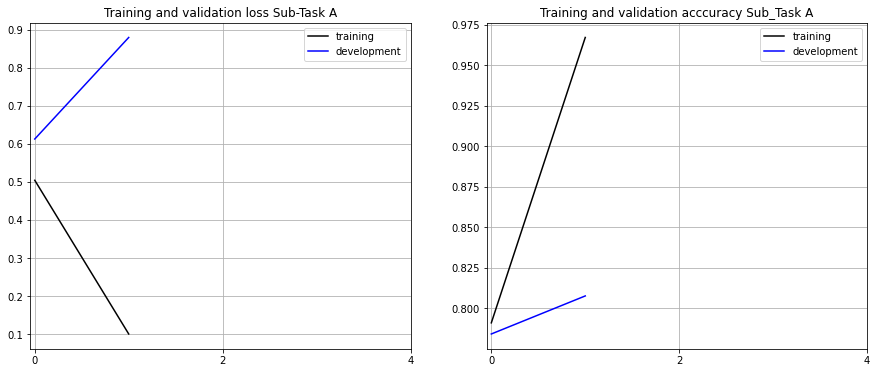

In [113]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='A')

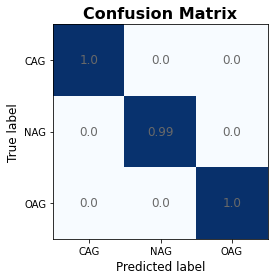

              precision    recall  f1-score   support

         CAG      0.993     0.996     0.994      2718
         NAG      0.995     0.990     0.992      4045
         OAG      0.992     0.996     0.994      2610

    accuracy                          0.993      9373
   macro avg      0.993     0.994     0.994      9373
weighted avg      0.993     0.993     0.993      9373

Weighted f1-score: 0.9934902793251411


In [114]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_A.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_a, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_a, pred_labels_train, pos_label=1, average='weighted')}")


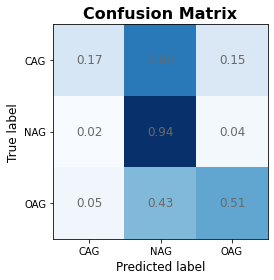

              precision    recall  f1-score   support

         CAG      0.444     0.171     0.247       117
         NAG      0.859     0.937     0.896       836
         OAG      0.527     0.513     0.520       113

    accuracy                          0.808      1066
   macro avg      0.610     0.540     0.554      1066
weighted avg      0.779     0.808     0.785      1066

Weighted f1-score: 0.785229258699036


In [115]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_A.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_a, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_a, pred_labels_dev, pos_label=1, average='weighted')}")

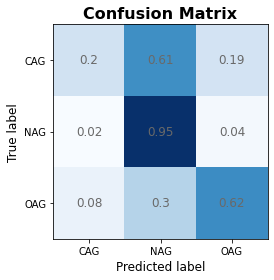

              precision    recall  f1-score   support

         CAG      0.564     0.196     0.291       224
         NAG      0.745     0.946     0.834       690
         OAG      0.724     0.622     0.669       286

    accuracy                          0.729      1200
   macro avg      0.678     0.588     0.598      1200
weighted avg      0.706     0.729     0.693      1200

Weighted f1-score: 0.6934129957102037


In [116]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_A.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'A')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_a, task='A', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_a, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_a, pred_labels_test, pos_label=1, average='weighted')}")

In [117]:
# save model
BERT_model_A.save_pretrained('drive/MyDrive/w266/saved_models/TRAC-2_BERT_model_A_oversampled')

## Model Task B

In [28]:
# delete model if exists
try:
    del BERT_model_B
except:
    pass

In [29]:
# define the model. Task B is a classification task with 2 labels
BERT_model_B = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# compile model
BERT_model_B.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                     metrics=tf.metrics.CategoricalAccuracy()
                    )

In [31]:
# fit model
training_history = BERT_model_B.fit(train_tf_dataset_b, validation_data=dev_tf_dataset_b, epochs=3)

Epoch 1/3
586/586 [==============================] - 221s 353ms/step - loss: 0.2031 - categorical_accuracy: 0.9271 - val_loss: 0.2417 - val_categorical_accuracy: 0.9503
Epoch 2/3
586/586 [==============================] - 204s 349ms/step - loss: 0.0395 - categorical_accuracy: 0.9889 - val_loss: 0.3679 - val_categorical_accuracy: 0.9428
Epoch 3/3
586/586 [==============================] - 204s 348ms/step - loss: 0.0248 - categorical_accuracy: 0.9931 - val_loss: 0.3476 - val_categorical_accuracy: 0.9437


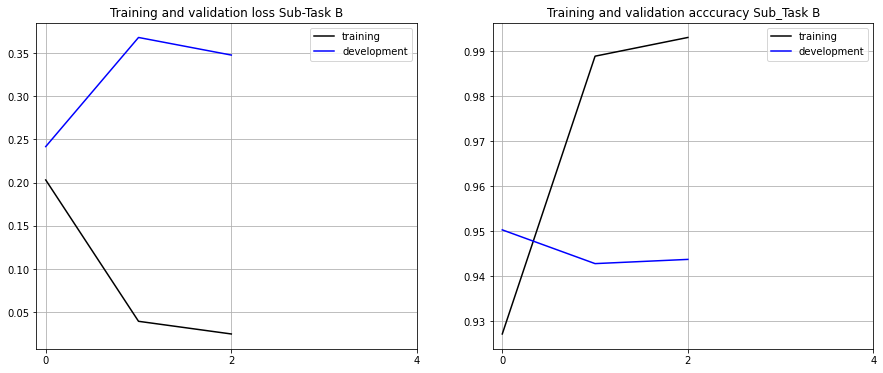

In [32]:
# plot loss and accuracy
loss_accuracy_plots(training_history, xrange=5, task='B')

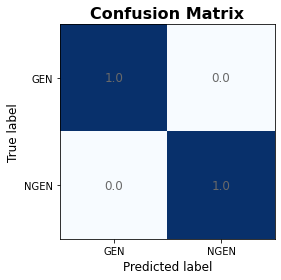

              precision    recall  f1-score   support

         GEN      0.997     0.998     0.998      1854
        NGEN      0.999     0.999     0.999      7519

    accuracy                          0.999      9373
   macro avg      0.998     0.999     0.998      9373
weighted avg      0.999     0.999     0.999      9373

Weighted f1-score: 0.9990398926707789


In [33]:
# Evaluate model on TRAINING data

# predict using model. Returns logits
pred_labels_train = BERT_model_B.predict(train_features)[0]

# convert logits lo labels
pred_labels_train = from_logits_to_labels(pred_labels_train, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_train, train_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(train_labels_b, pred_labels_train, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(train_labels_b, pred_labels_train, pos_label=1, average='weighted')}")


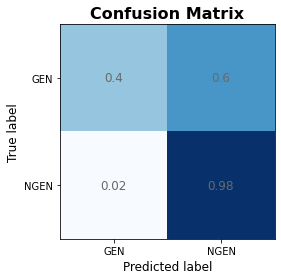

              precision    recall  f1-score   support

         GEN      0.644     0.397     0.492        73
        NGEN      0.957     0.984     0.970       993

    accuracy                          0.944      1066
   macro avg      0.801     0.691     0.731      1066
weighted avg      0.936     0.944     0.937      1066

Weighted f1-score: 0.9374281767065149


In [34]:
# Evaluate model on DEVELOPMENT data

# predict using model. Returns logits
pred_labels_dev = BERT_model_B.predict(dev_features)[0]

# convert logits lo labels
pred_labels_dev = from_logits_to_labels(pred_labels_dev, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_dev, dev_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(dev_labels_b, pred_labels_dev, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(dev_labels_b, pred_labels_dev, pos_label=1, average='weighted')}")

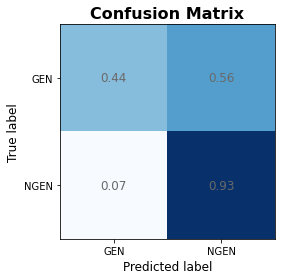

              precision    recall  f1-score   support

         GEN      0.527     0.440     0.480       175
        NGEN      0.907     0.933     0.920      1025

    accuracy                          0.861      1200
   macro avg      0.717     0.686     0.700      1200
weighted avg      0.852     0.861     0.856      1200

Weighted f1-score: 0.855517607464648


In [35]:
# Evaluate model on TEST data

# predict using model. Returns logits
pred_labels_test = BERT_model_B.predict(test_features)[0]

# convert logits lo labels
pred_labels_test = from_logits_to_labels(pred_labels_test, 'B')

# confusion matrix
confusion_matrix_plot(pred_labels_test, test_labels_b, task='B', normalize='true')

# print the precision, recall, f1
print(metrics.classification_report(test_labels_b, pred_labels_test, digits=3))

# print global weighted f-1 score
print(f"Weighted f1-score: {metrics.f1_score(test_labels_b, pred_labels_test, pos_label=1, average='weighted')}")

In [36]:
# save model
BERT_model_B.save_pretrained('drive/MyDrive/w266/saved_models/TRAC-2_BERT_model_B_oversampled')

## References

- Pre-processing data: https://huggingface.co/transformers/preprocessing.html

- Fine-tunning a pre-trained model: https://huggingface.co/transformers/training.html

- BERT: https://huggingface.co/transformers/model_doc/bert.html